# Vehicle Detection 

In this project I wrote a software pipeline that detects vehicles in an image and then effectively a video stream. This is an important skill for practical Self-Driving Cars to have to help in the decision making process. This is the finished product but a number of implementations were explored in the playground notebook in the directory. 

### Approach

In order to identify Vehicles a Classifier was trained and then used to effectively identify vehicles in the images. 

### Import the libraries needed

In [1]:
import numpy as np
import cv2
import sys
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab as pl
import random
import glob
import time

# SCiKit Learn Stuff
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label


%matplotlib inline

### Load the data for training the Classifier. Images of Both cars and things that are not cars were used to train the classifer. 

In [2]:
cars = glob.glob('exploration_data_large/vehicles/**/*.png')
notcars = glob.glob('exploration_data_large/non-vehicles/**/*.png')

        
print(len(cars) + len(notcars))
print(len(cars), len(notcars))

17760
8792 8968


### Load some Test Images

In [3]:
test_image_files = glob.glob('test_images/test*.jpg')
test_images = []

for image_file in test_image_files:
    test_images.append(mpimg.imread(image_file))
    
print(len(test_images))

6


### Define functions used to Extract Featuures from the training data

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
def convert_color(img, conv='RGB'):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return np.copy(img)

In [8]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'color_space'
        feature_image = convert_color(image, color_space)    
        
        # Spatial features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        # Color histogram
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        # HOG Features
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Define parameters to be used and Extract the Features

In [224]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 700] # Min and max in y to search in slide_window()
xstart = 400

In [79]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

### Train the Classifier

In [80]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('X.shape is {}'.format(X.shape))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=50)
# Check the training time for the SVC
X_train, y_train = shuffle(X_train, y_train)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

X.shape is (17760, 2004)
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2004
3.49 Seconds to train SVC...
Test Accuracy of SVC =  0.987


In [81]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy', min_samples_split=20)

# Shuffle Training Data Again
X_train, y_train = shuffle(X_train, y_train)
t=time.time()
decision_tree.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Decision Tree...')
# Check the score of the SVC
print('Test Accuracy of Decision Tree = ', round(decision_tree.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

37.58 Seconds to train Decision Tree...
Test Accuracy of Decision Tree =  0.9352


In [82]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
# Shuffle Training Data Again
X_train, y_train = shuffle(X_train, y_train)
t=time.time()
naive_bayes.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Gaussian Naive Bayes...')
# Check the score of the SVC
print('Gaussian Naive Bayes = ', round(naive_bayes.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

0.62 Gaussian Naive Bayes...
Gaussian Naive Bayes =  0.9527


### Define a function that can extract features from image and predict

In [234]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, box_list):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
        
            reshaped = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(reshaped)    
            
            test_prediction = svc.predict(test_features)
            tree_prediction = decision_tree.predict(test_features)
            nb_prediction = naive_bayes.predict(test_features)
#             dec = svc.decision_function(test_features)
#             test_prediction = int(dec > 0.9)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            x1, y1, x2, y2 = xbox_left+xstart, ytop_draw+ystart, xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart
            
            if test_prediction == 1 and nb_prediction == 1 and tree_prediction == 1:
                cv2.rectangle(draw_img,(x1, y1),(x2, y2),(0,0,255),6) 
                box_list.append(((x1, y1),(x2, y2)))
            
    return draw_img
    


2 boxes


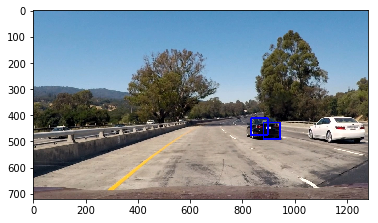

In [235]:
test_image = test_images[0]

ystart, ystop = y_start_stop

scale = 1

box_list = []
out_img = find_cars(test_image, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, box_list)

print('{} boxes'.format(len(box_list)))
plt.imshow(out_img)

0 boxes


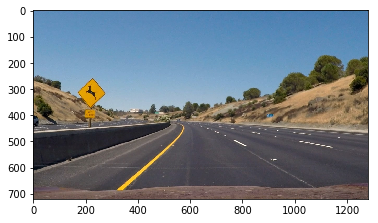

In [236]:
test_image = test_images[1]

ystart, ystop = y_start_stop

scale = 1

box_list = []
out_img = find_cars(test_image, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, box_list)

print('{} boxes'.format(len(box_list)))
plt.imshow(out_img)

1 boxes


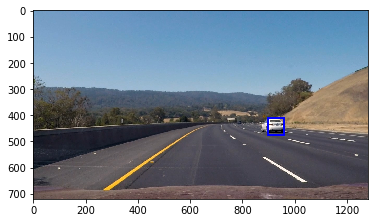

In [237]:
test_image = test_images[2]

ystart, ystop = y_start_stop

scale = 1

box_list = []
out_img = find_cars(test_image, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, box_list)

print('{} boxes'.format(len(box_list)))
plt.imshow(out_img)

4 boxes


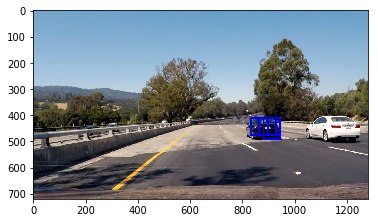

In [238]:
test_image = test_images[3]

ystart, ystop = y_start_stop

scale = 1

box_list = []
out_img = find_cars(test_image, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, box_list)

print('{} boxes'.format(len(box_list)))
plt.imshow(out_img)

3 boxes


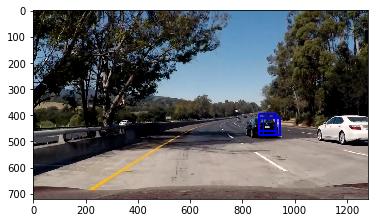

In [239]:
test_image = test_images[4]

ystart, ystop = y_start_stop

scale = 1

box_list = []
out_img = find_cars(test_image, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, box_list)

print('{} boxes'.format(len(box_list)))
plt.imshow(out_img)

0 boxes


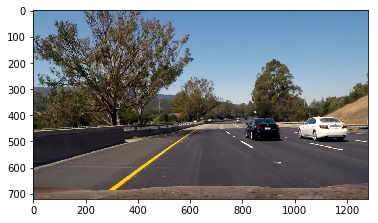

In [240]:
test_image = test_images[5]

ystart, ystop = y_start_stop

scale = 1

box_list = []
out_img = find_cars(test_image, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, box_list)

print('{} boxes'.format(len(box_list)))
plt.imshow(out_img)

In [232]:
# Gather boxes at different scales
def find_boxes(img, scale_start=1, scale_end=3, incr=.2):
    boxes = []
    scale = scale_start
    while scale <= scale_end:
        find_cars(img, xstart, ystart, ystop, scale, svc, X_scaler, orient,
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, boxes)
        scale += incr
        
    out_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(out_img,box[0],box[1],(0,0,255),6) 
    return out_img, boxes

21 boxes


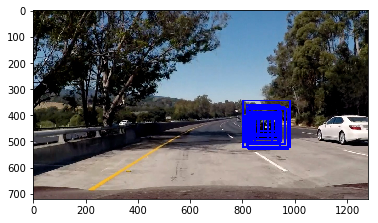

In [241]:
test_image = test_images[4]
out_img, boxes = find_boxes(test_image)

print('{} boxes'.format(len(boxes)))
plt.imshow(out_img)

### Identify cars using a heatmap

In [242]:
# Used to build the heat map by adding 'heat' - really just 1 bits
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [243]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [244]:
# Draw boxes around the Vehicles
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [245]:
# Build final image with Vehicles clearly identfied
def get_labelled_image(image, box_list, threshold=2):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [246]:
# Define a class to process image + remember data from previous frames
class Vehicle:
    def __init__(self):
        # history of rectangles previous n frames
        self.skip_frame = False
        self.frame_skip = 0
        self.prev_labels = None
        
    def process_image(self, image):
        if 1 <= self.frame_skip <= 10: # Only so much can change within a few frames :)
            self.frame_skip += 1
            draw_img = draw_labeled_bboxes(np.copy(image), self.prev_labels)
            return draw_img
        elif self.frame_skip > 10:
            self.frame_skip = 0
        out_image, boxes = find_boxes(image)
        
        
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        
#         print(self.prev_boxes)
        # Add heat to each box in box list
        heat = add_heat(heat,boxes)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        self.prev_labels = labels
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        self.frame_skip += 1
        return draw_img

3.97788 Seconds to label boxes


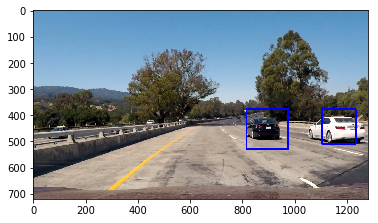

In [247]:
test_image = test_images[0]
v = Vehicle()
t=time.time()
final = v.process_image(test_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to label boxes')

plt.imshow(final)

3.98574 Seconds to label boxes


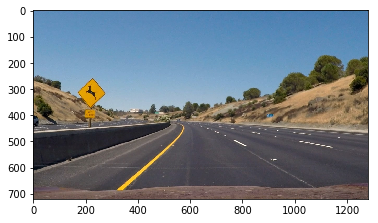

In [248]:
test_image = test_images[1]
v = Vehicle()
t=time.time()
final = v.process_image(test_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to label boxes')

plt.imshow(final)

4.041 Seconds to label boxes


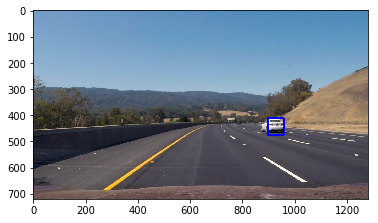

In [249]:
test_image = test_images[2]
v = Vehicle()
t=time.time()
final = v.process_image(test_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to label boxes')

plt.imshow(final)

3.98572 Seconds to label boxes


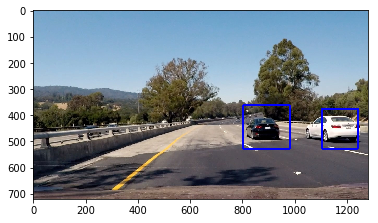

In [250]:
test_image = test_images[3]
v = Vehicle()
t=time.time()
final = v.process_image(test_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to label boxes')

plt.imshow(final)

3.95651 Seconds to label boxes


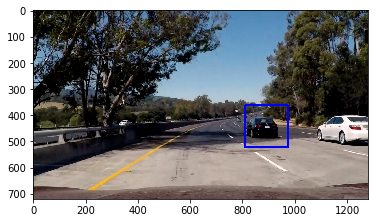

In [251]:
test_image = test_images[4]
v = Vehicle()
t=time.time()
final = v.process_image(test_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to label boxes')

plt.imshow(final)

3.94191 Seconds to label boxes


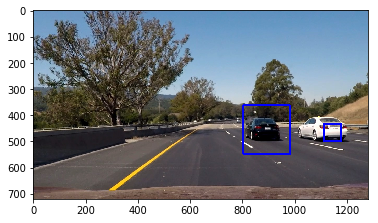

In [252]:
test_image = test_images[5]
v = Vehicle()
t=time.time()
final = v.process_image(test_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to label boxes')

plt.imshow(final)

### Apply to video Stream

In [202]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [212]:
video_output = 'output_videos/test_video.mp4'
v = Vehicle()
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(v.process_image) 
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4



 97%|█████████▋| 38/39 [00:17<00:00,  2.13it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 17.4 s, sys: 625 ms, total: 18 s
Wall time: 18.8 s


In [218]:
i=0
video_output2 = 'output_videos/project_video{}.mp4'.format(i)
v = Vehicle()
clip2 = VideoFileClip("project_video.mp4").subclip(i,i+15)
project_clip2 = clip2.fl_image(v.process_image) 
%time project_clip2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video0.mp4
[MoviePy] Writing video output_videos/project_video0.mp4



100%|█████████▉| 375/376 [03:27<00:00,  1.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video0.mp4 

CPU times: user 3min 18s, sys: 7.23 s, total: 3min 25s
Wall time: 3min 28s


In [219]:
i+=15
video_output2 = 'output_videos/project_video{}.mp4'.format(i)
v = Vehicle()
clip2 = VideoFileClip("project_video.mp4").subclip(i,i+15)
project_clip2 = clip2.fl_image(v.process_image) 
%time project_clip2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video15.mp4
[MoviePy] Writing video output_videos/project_video15.mp4


100%|█████████▉| 375/376 [03:26<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video15.mp4 

CPU times: user 3min 17s, sys: 6.95 s, total: 3min 24s
Wall time: 3min 26s


In [220]:
i+=15
video_output2 = 'output_videos/project_video{}.mp4'.format(i)
v = Vehicle()
clip2 = VideoFileClip("project_video.mp4").subclip(i,i+15)
project_clip2 = clip2.fl_image(v.process_image) 
%time project_clip2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video30.mp4
[MoviePy] Writing video output_videos/project_video30.mp4


100%|█████████▉| 375/376 [03:25<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video30.mp4 

CPU times: user 3min 18s, sys: 6.81 s, total: 3min 24s
Wall time: 3min 26s


In [ ]:
video_output2 = 'output_videos/project_video.mp4'
v = Vehicle()
clip2 = VideoFileClip("project_video.mp4")
project_clip2 = clip2.fl_image(v.process_image) 
%time project_clip2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 93%|█████████▎| 1175/1261 [07:17<00:32,  2.64it/s]